In [1]:
# ======================================
# 0. Core libs (DAY1~DAY9 공통)
# ======================================
import numpy as np
import pandas as pd

import shutil
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import matplotlib.font_manager as fm
from matplotlib import rcParams

# ======================================
# 1) Style FIRST (폰트보다 먼저)
# ======================================
plt.style.use("_mpl-gallery-nogrid")
sns.set_theme(style="white")
sns.set_style("ticks")
sns.set_context("notebook")

# ======================================
# 2) Font (NanumGothic) — style 적용 후 "고정"
# ======================================
FONT_DIR = Path(r"E:\Portfolio_ver1\seoul_pv_load_analysis\fonts")
FONT_PATH = FONT_DIR / "NanumGothic.ttf"

if not FONT_PATH.exists():
    raise FileNotFoundError(f"폰트 파일 없음: {FONT_PATH}")

fm.fontManager.addfont(str(FONT_PATH))
font_name = fm.FontProperties(fname=str(FONT_PATH)).get_name()

rcParams["font.family"] = font_name
rcParams["axes.unicode_minus"] = False

# (선택) 기본 글자 크기 통일
rcParams["font.size"] = 12
rcParams["axes.titlesize"] = 18
rcParams["axes.labelsize"] = 14
rcParams["xtick.labelsize"] = 12
rcParams["ytick.labelsize"] = 12

# 개별 객체용 (필요할 때만)
font_prop = fm.FontProperties(fname=str(FONT_PATH))

print("✅ Style+Font ready:", font_name)

✅ Style+Font ready: NanumGothic


### DAY 3: 태양광 이론적 시간대 발전 패턴 생성

**목적**
- 실제 발전량이 아닌 시간대 패턴 중심의 태양광 발전 특성 정의

**주요 작업**
- 정오 중심의 이론적 PV 발전 곡선 생성
- 부하 패턴과 비교 가능하도록 정규화

**산출물**
- 태양광 시간대 발전 패턴 곡선

In [ ]:
'''
Day 3 — 목표

Day 3에서는 태양광 발전을 절대량이 아닌 ‘시간대 분포 구조’로 해석하고,  
전력 부하와의 시간대 불일치 구조를 비교·분석할 수 있는 이론적 PV 기준 패턴을 구축한다.

'''

In [2]:
# 1. 데이터 로드 + Day1 로직으로 datetime/value 생성 → df_base 확정

# ------------------------------------------------------------
# 입력 데이터 확보 (최종본)
# - CWD: .../notebooks 기준
# - 데이터 위치: PROJECT_ROOT/data/법정동별시간별전력사용량.csv
# - 원본에 datetime/value 없으면 Day1 로직으로 생성
# ------------------------------------------------------------

PROJECT_ROOT = Path.cwd().parent          # .../seoul_pv_load_analysis
DATA_DIR = PROJECT_ROOT / "data"
LOAD_FILE = DATA_DIR / "법정동별시간별전력사용량.csv"
OUT_DIR = PROJECT_ROOT / "outputs"
OUT_DIR.mkdir(exist_ok=True)
FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)

SAVE_KWARGS = dict(
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.1
)

print("CWD:", Path.cwd())
print("PROJECT_ROOT:", PROJECT_ROOT)
print("CSV exists?", LOAD_FILE.exists())
print("CSV path:", LOAD_FILE)

if not LOAD_FILE.exists():
    raise FileNotFoundError(f"데이터 파일을 찾을 수 없습니다: {LOAD_FILE}")

# 인코딩 자동 시도
encodings_to_try = ["utf-8-sig", "utf-8", "cp949", "euc-kr"]
df = None
last_error = None
for enc in encodings_to_try:
    try:
        df = pd.read_csv(LOAD_FILE, encoding=enc)
        print(f"✅ CSV 로드 성공 (encoding={enc}) | shape={df.shape}")
        break
    except Exception as e:
        last_error = e

if df is None:
    raise RuntimeError(f"CSV 로드 실패. 마지막 에러: {last_error}")

# --- Day1 로직 반영: datetime 생성 (없을 때)
if "datetime" not in df.columns:
    # Day1 전제 컬럼 체크
    required = {"USE_YM", "USE_HM"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"df에 datetime이 없고, {missing} 컬럼도 없습니다. 컬럼명을 확인해주세요.")
    
    df["date"] = pd.to_datetime(df["USE_YM"], format="%Y%m%d", errors="coerce")
    # ✅ Day1과 동일하게 -1 적용 (일관성 유지)
    df["hour"] = (df["USE_HM"] // 100 - 1).astype("Int64")
    df["datetime"] = df["date"] + pd.to_timedelta(df["hour"].fillna(0), unit="h")

# --- month/hour 파생 (혹시 없으면 생성)
df["datetime"] = pd.to_datetime(df["datetime"])
df["month"] = df["datetime"].dt.month
df["hour"] = df["datetime"].dt.hour

# --- value 생성 (없을 때)
if "value" not in df.columns:
    if "FDRCT_VLD_KWH" not in df.columns:
        raise ValueError("df에 value도 없고 FDRCT_VLD_KWH도 없습니다. 전력 사용량 컬럼명 확인 필요.")
    df["value"] = pd.to_numeric(
        df["FDRCT_VLD_KWH"].astype(str).str.replace(",", ""),
        errors="coerce"
    )

# --- Day1 최소 테이블 확정
df_base = df[["datetime", "month", "hour", "value"]].copy()

print("df_base:", df_base.shape)
display(df_base.head())
print("hour 범위:", int(df_base["hour"].min()), "~", int(df_base["hour"].max()))
print("value 결측률(%):", round(df_base["value"].isna().mean() * 100, 4))


CWD: e:\Portfolio_ver1\seoul_pv_load_analysis\notebooks
PROJECT_ROOT: e:\Portfolio_ver1\seoul_pv_load_analysis
CSV exists? True
CSV path: e:\Portfolio_ver1\seoul_pv_load_analysis\data\법정동별시간별전력사용량.csv
✅ CSV 로드 성공 (encoding=utf-8-sig) | shape=(9754804, 5)
df_base: (9754804, 4)


,datetime,month,hour,value
0,2022-06-28,6,0,10782.0565
1,2022-06-28,6,0,11394.8635
2,2022-06-28,6,0,7273.9620
3,2022-06-28,6,0,11008.8110
4,2022-06-28,6,0,2905.1120


hour 범위: 0 ~ 23
value 결측률(%): 0.0


In [3]:
# 2. DAY 2 핵심 산출물 재구성: 24시간 평균 부하 프로파일

# 24시간 평균 부하 프로파일(DAY 2 산출물 역할)
load_profile_24h = (df_base.dropna(subset = ["value"]).groupby("hour", as_index = False)["value"]
                    .agg(load_mean = "mean", load_std = "std").sort_values("hour"))

peak_hour = int(load_profile_24h.loc[load_profile_24h["load_mean"].idxmax(), "hour"])
load_peak = float(load_profile_24h["load_mean"].max())

print("peak_hour =", peak_hour, "| load_peak =", load_peak)
display(load_profile_24h)

peak_hour = 13 | load_peak = 7647.383917127698


,hour,load_mean,load_std
0,0,4828.966546,15855.283528
1,1,4436.061656,14999.609193
2,2,4301.931715,15795.194031
3,3,4069.172541,13469.363720
4,4,4467.956892,28206.642910
5,5,4570.492076,26689.943413
6,6,5000.093613,16905.561280
7,7,5677.409920,16451.921541
8,8,6575.992184,18452.542962
9,9,7246.801206,26311.111687


In [5]:
# 3. PV 이론 패턴 함수 (정규화 0 ~ 1) + 계절 훅 포함

def season_from_month(month: int) -> str:
    if month in [12, 1, 2]:
        return "winter"
    if month in [3, 4, 5]:
        return "spring"
    if month in [6, 7, 8]:
        return "summer"
    return "fall"

def pv_params_by_season(season: str):
    # 서울 기준 "합리적 근사값"
    params = {
        "winter": dict(sunrise = 8, sunset = 17, peak = 12, sigma = 1.8),
        "spring": dict(sunrise = 7, sunset = 19, peak = 13, sigma = 2.2),
        "summer": dict(sunrise = 5, sunset = 20, peak = 13, sigma = 2.6),
        "fall": dict(sunrise = 7, sunset = 18, peak = 12, sigma = 2.1),
    }
    return params[season]

def make_pv_profile(hours = range(24), month = None, sunrise = None, sunset = None, peak = None, sigma = None):
    '''
    반환: DataFrame(hour, pv_norm)
    - pv_norm: 0 ~ 1 정규화된 pv 이론 패턴
    - day light(일출 ~ 일몰) 밖은 0
    '''
    hours = np.array(list(hours), dtype = int)

    # month 입력 시 계절 파라미터 자동 적용 (확장 훅)
    if month is not None and (sunrise is None or sunset is None or peak is None or sigma is None):
        s = season_from_month(int(month))
        p = pv_params_by_season(s)
        sunrise, sunset, peak, sigma = p["sunrise"], p["sunset"], p["peak"], p["sigma"]

    # 기본값
    sunrise = 7 if sunrise is None else sunrise
    sunset = 19 if sunset is None else sunset
    peak = 13 if peak is None else peak
    sigma = 2.3 if sigma is None else sigma

    # 가우시안 종모양
    pv = np.exp(-0.5 * ((hours - peak) / sigma) ** 2)

    # 일출 ~ 일몰 밖은 0
    pv[(hours < sunrise)|(hours > sunset)] = 0.0

    # 정규화
    if pv.max() > 0:
        pv = pv / pv.max()
    
    return pd.DataFrame({"hour": hours, "pv_norm": pv})

In [6]:
# 4. PV 프로파일 생성 + 검증

pv_profile_24h = make_pv_profile() # 기본 (봄 / 가을 근사)
display(pv_profile_24h)

# 필수 검증
assert pv_profile_24h["pv_norm"].min() >= 0, "pv_norm min < 0"
assert pv_profile_24h["pv_norm"].max() <= 1.0000001, "pv_norm max > 1"
print("pv_norm 검증 통과 (0 ~ 1)")

,hour,pv_norm
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,0.000000
4,4,0.000000
5,5,0.000000
6,6,0.000000
7,7,0.033285
8,8,0.094142
9,9,0.220405


pv_norm 검증 통과 (0 ~ 1)


In [7]:
# 5. 시나리오 스케일링(PV 피크를 부하 피크의 X% 로)

def scale_pv_to_load(pv_profile_24h: pd.DataFrame, load_peak: float, pv_capacity_ratio: float) -> pd.DataFrame:
    '''
    pv_capacity_ratio: PV 피크를 부하 피크의 몇 %로 볼지 (0.1 = 10%, 0.2 = 20%,...)
    반환: pv_kW 컬럼이 추가된 DF
    '''
    out = pv_profile_24h.copy()
    out["pv_kW"] = out["pv_norm"] * (load_peak * pv_capacity_ratio)
    return out

pv_ratio = 0.2 # 대표 시나리오 (20%)
pv_scale_24h = scale_pv_to_load(pv_profile_24h, load_peak = load_peak, pv_capacity_ratio = pv_ratio)
display(pv_scale_24h)

,hour,pv_norm,pv_kW
0,0,0.000000,0.000000
1,1,0.000000,0.000000
2,2,0.000000,0.000000
3,3,0.000000,0.000000
4,4,0.000000,0.000000
5,5,0.000000,0.000000
6,6,0.000000,0.000000
7,7,0.033285,50.908733
8,8,0.094142,143.988297
9,9,0.220405,337.104729


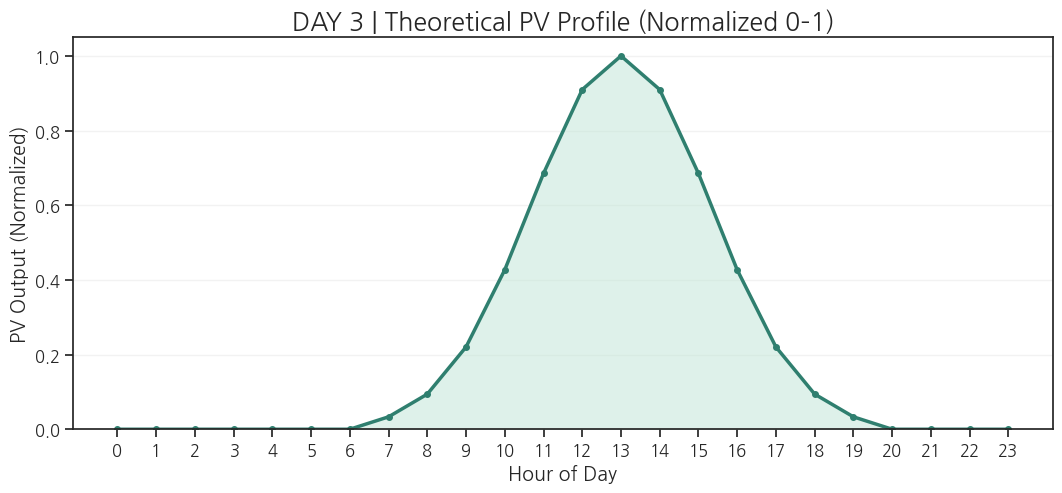

In [8]:
# 6. 병합테이블 + 시각화 2장

# (A) PV 정규화 곡선
# =========================
# 색상 & 스타일 (DAY 2와 통일)
# =========================
LINE_COLOR = "#2F7F6F"   # 진한 그린
FILL_COLOR = "#BFE5D6"   # 연한 그린

# =========================
# 그래프
# =========================
plt.figure(figsize=(10, 4))

# PV 프로파일 라인
plt.plot(
    pv_profile_24h["hour"],
    pv_profile_24h["pv_norm"],
    color=LINE_COLOR,
    linewidth=2.5,
    marker="o",
    markersize=4,
    label="Theoretical PV Output"
)

# 선 아래 음영 (발전 가능 구간 강조)
plt.fill_between(
    pv_profile_24h["hour"],
    pv_profile_24h["pv_norm"],
    color=FILL_COLOR,
    alpha=0.5
)

# 축 설정
plt.xticks(np.arange(0, 24, 1))
plt.xlabel("Hour of Day")
plt.ylabel("PV Output (Normalized)")

# 제목
plt.title("DAY 3 | Theoretical PV Profile (Normalized 0–1)")

# 그리드 (y축만, 은은하게)
plt.grid(axis="y", alpha=0.25)

# y축 여백
plt.ylim(0, 1.05)

# 저장
plt.savefig(
    FIG_DIR / "DAY3_theoretical_pv_profile.png",
    **SAVE_KWARGS
)

plt.show()

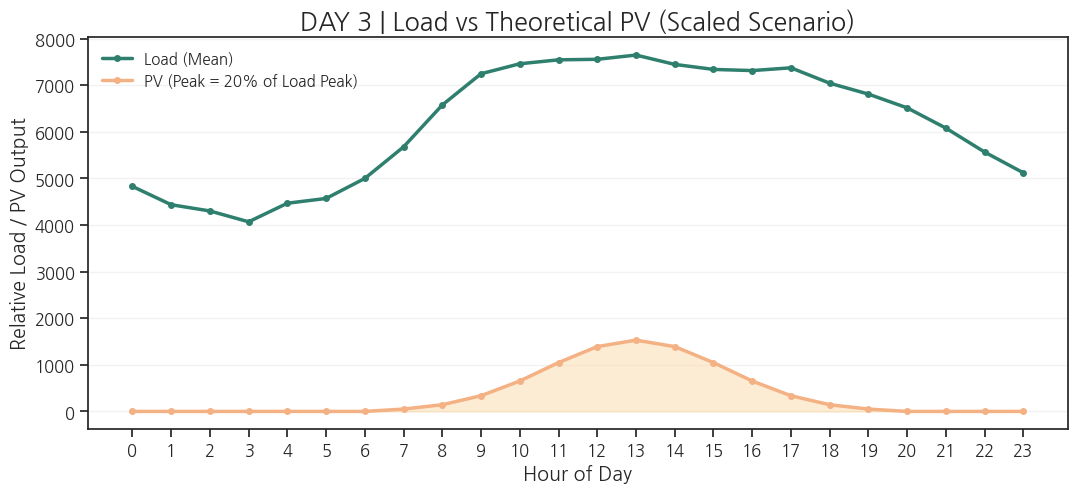

,hour,load_mean,load_std,pv_norm,pv_kW
0,0,4828.966546,15855.283528,0.0,0.0
1,1,4436.061656,14999.609193,0.0,0.0
2,2,4301.931715,15795.194031,0.0,0.0
3,3,4069.172541,13469.363720,0.0,0.0
4,4,4467.956892,28206.642910,0.0,0.0


In [9]:
# (B) 평균 부하 VS PV (스케일 20%)
# =========================
# 데이터 병합
# =========================
merged = (
    load_profile_24h
    .merge(pv_scale_24h, on="hour", how="left")
    .sort_values("hour")
)

# =========================
# 색상 (DAY 2/3 통일)
# =========================
LOAD_COLOR = "#2F7F6F"   # 진한 그린 (부하)
PV_COLOR   = "#F4B183"   # 소프트 오렌지 (태양광)
PV_FILL    = "#FAD7A0"   # 연한 오렌지

# =========================
# 그래프
# =========================
plt.figure(figsize=(10, 4))

# Load (평균)
plt.plot(
    merged["hour"],
    merged["load_mean"],
    color=LOAD_COLOR,
    linewidth=2.5,
    marker="o",
    markersize=4,
    label="Load (Mean)"
)

# PV (스케일 적용)
plt.plot(
    merged["hour"],
    merged["pv_kW"],
    color=PV_COLOR,
    linewidth=2.5,
    marker="o",
    markersize=4,
    label=f"PV (Peak = {int(pv_ratio * 100)}% of Load Peak)"
)

# PV 영역 음영 (발전 가능 시간대 강조)
plt.fill_between(
    merged["hour"],
    merged["pv_kW"],
    color=PV_FILL,
    alpha=0.45
)

# 축 / 제목
plt.xticks(np.arange(0, 24, 1))
plt.xlabel("Hour of Day")
plt.ylabel("Relative Load / PV Output")
plt.title("DAY 3 | Load vs Theoretical PV (Scaled Scenario)")

# 그리드 (y축만)
plt.grid(axis="y", alpha=0.25)

# 범례
plt.legend(frameon=False)

# 저장
plt.savefig(
    FIG_DIR / f"DAY3_load_vs_pv_scaled_{int(pv_ratio * 100)}pct.png",
    **SAVE_KWARGS
)

plt.show()

# 확인용
display(merged.head())

In [10]:
# 7. DAY 3 결론

print("===DAY 3 Conclusion===")
print("1) 실제 pv 발전량 대신, 시간대 구조 비교를 위한 이론적 pv 패턴(pv_norm, 0 ~ 1)을 생성했다.")
print("2) pv_norm은 일출 ~ 일몰 외 시간대를 0으로 처리했고, 최대값 1로 정규화 했다.")
print(f"3) 시나리오 스케일링으로 PV 피크를 부하 피크의 {int(pv_ratio * 100)}%로 맞춘 pv_KW를 구성했다.")
print("4) DAY 4에서는 net_load = load_mean - pv_kW를 기반으로 덕 커브(시간대 불일치) 지표를 계산한다.")

===DAY 3 Conclusion===
1) 실제 pv 발전량 대신, 시간대 구조 비교를 위한 이론적 pv 패턴(pv_norm, 0 ~ 1)을 생성했다.
2) pv_norm은 일출 ~ 일몰 외 시간대를 0으로 처리했고, 최대값 1로 정규화 했다.
3) 시나리오 스케일링으로 PV 피크를 부하 피크의 20%로 맞춘 pv_KW를 구성했다.
4) DAY 4에서는 net_load = load_mean - pv_kW를 기반으로 덕 커브(시간대 불일치) 지표를 계산한다.


In [11]:
# Day 3 output: theoretical PV profile
day3_out = pv_profile_24h.copy()

day3_out.to_csv(
    OUT_DIR / "DAY3_pv_theoretical_profile.csv",
    index=False,
    encoding="utf-8-sig"
)

print("Saved: outputs/DAY3_pv_theoretical_profile.csv")

Saved: outputs/DAY3_pv_theoretical_profile.csv


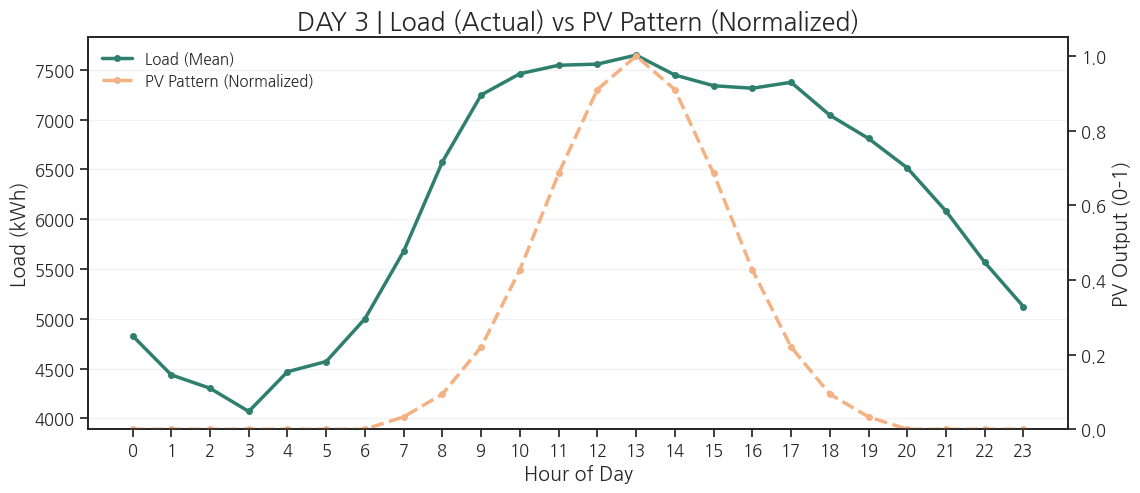

In [12]:
# A 기준: Load는 실제값(load_mean), PV는 정규화 패턴(pv_norm, 0~1)

# =========================
# 데이터
# =========================
merged_A = (
    load_profile_24h
    .merge(pv_profile_24h[["hour", "pv_norm"]], on="hour", how="left")
    .sort_values("hour")
)

# =========================
# 색상 (DAY 2/3 통일)
# =========================
LOAD_COLOR = "#2F7F6F"   # 진한 그린
PV_COLOR   = "#F4B183"   # 소프트 오렌지

# =========================
# Figure & Axes
# =========================
fig, ax1 = plt.subplots(figsize=(10, 4))

# --- 좌측축: Load (실제 부하) ---
ax1.plot(
    merged_A["hour"],
    merged_A["load_mean"],
    color=LOAD_COLOR,
    linewidth=2.5,
    marker="o",
    markersize=4,
    label="Load (Mean)"
)

ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Load (kWh)")
ax1.set_xticks(np.arange(0, 24, 1))
ax1.grid(axis="y", alpha=0.25)

# --- 우측축: PV pattern (정규화) ---
ax2 = ax1.twinx()
ax2.plot(
    merged_A["hour"],
    merged_A["pv_norm"],
    color=PV_COLOR,
    linewidth=2.5,
    linestyle="--",
    marker="o",
    markersize=4,
    label="PV Pattern (Normalized)"
)

ax2.set_ylabel("PV Output (0–1)")
ax2.set_ylim(0, 1.05)

# =========================
# 범례 통합
# =========================
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]

ax1.legend(lines, labels, frameon=False, loc="upper left")

# =========================
# 제목
# =========================
plt.title("DAY 3 | Load (Actual) vs PV Pattern (Normalized)")

# =========================
# 저장
# =========================
plt.savefig(
    FIG_DIR / "DAY3_load_vs_pv_pattern_dual_axis.png",
    **SAVE_KWARGS
)

plt.show()


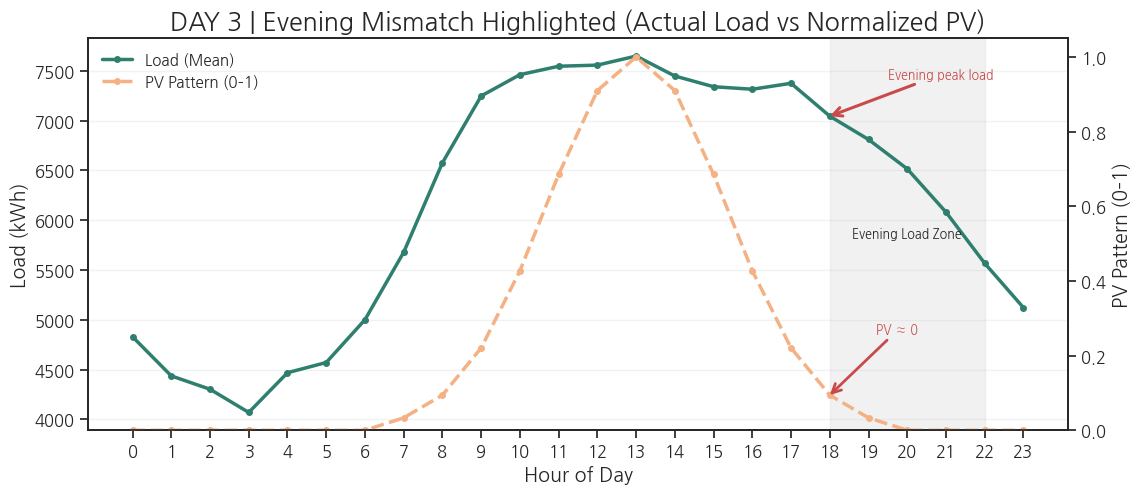

In [13]:
# =========================
# 구간 설정
# =========================
EV_START, EV_END = 18, 22

# =========================
# 색상 (DAY2/3 통일 톤)
# =========================
LOAD_COLOR = "#2F7F6F"   # 진한 그린
PV_COLOR   = "#F4B183"   # 소프트 오렌지
ZONE_COLOR = "#D9D9D9"   # 연한 회색(구간 강조)

# =========================
# 피크(저녁구간) 계산 — 셀 안에서 확정 (중요)
# =========================
mask = (merged_A["hour"] >= EV_START) & (merged_A["hour"] <= EV_END)
idx_peak = merged_A.loc[mask, "load_mean"].idxmax()

ph = int(merged_A.loc[idx_peak, "hour"])
load_ph = float(merged_A.loc[idx_peak, "load_mean"])
pv_ph   = float(merged_A.loc[idx_peak, "pv_norm"])

# =========================
# Figure
# =========================
fig, ax1 = plt.subplots(figsize=(10, 4))

# --- Load (좌측축) ---
ax1.plot(
    merged_A["hour"], merged_A["load_mean"],
    color=LOAD_COLOR, linewidth=2.5,
    marker="o", markersize=4,
    label="Load (Mean)"
)
ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Load (kWh)")
ax1.set_xticks(np.arange(0, 24, 1))
ax1.grid(axis="y", alpha=0.25)

# Evening zone 음영
ax1.axvspan(EV_START, EV_END, color=ZONE_COLOR, alpha=0.35, zorder=0)

# --- PV pattern (우측축) ---
ax2 = ax1.twinx()
ax2.plot(
    merged_A["hour"], merged_A["pv_norm"],
    color=PV_COLOR, linewidth=2.5,
    linestyle="--",
    marker="o", markersize=4,
    label="PV Pattern (0–1)"
)
ax2.set_ylabel("PV Pattern (0–1)")
ax2.set_ylim(0, 1.05)

# =========================
# 텍스트/콜아웃 (plot 이후 배치)
# =========================
# 구간 라벨
ax1.text(
    (EV_START + EV_END) / 2,   # x: 시간대 중앙 (데이터 좌표)
    0.5,                       # y: 축 중앙 (0~1, axes 기준)
    "Evening Load Zone",
    ha="center",
    va="center",
    fontsize=9,
    transform=ax1.get_xaxis_transform()
)

# Load 피크 콜아웃(하나만!)
ax1.annotate(
    "Evening peak load",
    xy=(ph, load_ph),
    xytext=(ph + 1.5, load_ph * 1.05),
    arrowprops=dict(
        arrowstyle="->",
        lw=2.2,
        color="#C94A4A",
        shrinkA=0,
        shrinkB=0,
        mutation_scale=16
    ),
    fontsize=9,
    color="#C94A4A",
    ha="left",
    va="bottom"
)

# PV≈0 콜아웃(우측축에!)
ax2.annotate(
    "PV ≈ 0",
    xy=(ph, pv_ph),
    xytext=(ph + 1.2, 0.25),
    arrowprops=dict(
        arrowstyle="->",
        lw=2.0,
        color="#C94A4A",
        shrinkA=0,
        shrinkB=0,
        mutation_scale=16
    ),
    fontsize=9,
    color="#C94A4A",
    ha="left",
    va="bottom"
)

# =========================
# 범례 통합
# =========================
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, frameon=False, loc="upper left")

# =========================
# 제목 & 저장
# =========================
plt.title("DAY 3 | Evening Mismatch Highlighted (Actual Load vs Normalized PV)")

plt.savefig(
    FIG_DIR / f"DAY3_evening_mismatch_EV{EV_START}-{EV_END}.png",
    **SAVE_KWARGS
)

plt.show()

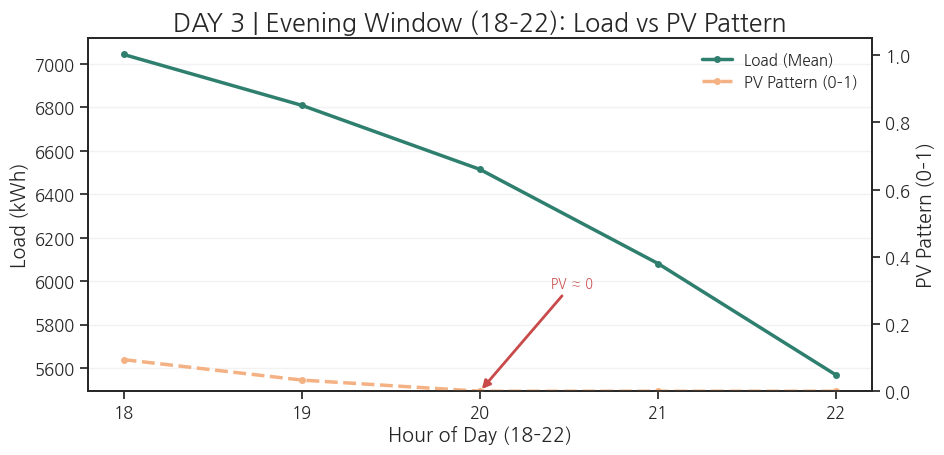

In [14]:
# =========================
# 구간 / 색상
# =========================
EV_START, EV_END = 18, 22

CALM_RED   = "#C94A4A"
LOAD_COLOR = "#2F7F6F"
PV_COLOR   = "#F4B183"

# =========================
# 데이터 (저녁 구간)
# =========================
m = merged_A[(merged_A["hour"] >= EV_START) & (merged_A["hour"] <= EV_END)].copy()
m = m.sort_values("hour")

# =========================
# Figure
# =========================
fig, ax1 = plt.subplots(figsize=(8, 3.6))

# --- Load (left axis) ---
ax1.plot(
    m["hour"], m["load_mean"],
    color=LOAD_COLOR, linewidth=2.5,
    marker="o", markersize=4,
    label="Load (Mean)"
)
ax1.set_xlabel("Hour of Day (18–22)")
ax1.set_ylabel("Load (kWh)")
ax1.set_xticks(np.arange(EV_START, EV_END + 1, 1))
ax1.grid(axis="y", alpha=0.25)

# --- PV (right axis) ---
ax2 = ax1.twinx()
ax2.plot(
    m["hour"], m["pv_norm"],
    color=PV_COLOR, linewidth=2.5,
    linestyle="--",
    marker="o", markersize=4,
    label="PV Pattern (0–1)"
)
ax2.set_ylabel("PV Pattern (0–1)")
ax2.set_ylim(0, 1.05)

# --- PV ≈ 0 콜아웃 (중앙 1개) ---
mid_hour = int(m["hour"].median())
mid_val  = float(m.loc[m["hour"] == mid_hour, "pv_norm"].iloc[0])

ax2.annotate(
    "PV ≈ 0",
    xy=(mid_hour, mid_val),
    xytext=(mid_hour + 0.4, 0.3),
    arrowprops=dict(
        arrowstyle="-|>",
        lw=2.0,
        color=CALM_RED,
        mutation_scale=12
    ),
    fontsize=9,
    color=CALM_RED,
    ha="left",
    va="bottom"
)

# --- Legend combine ---
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper right", frameon=False)

# --- Title ---
plt.title("DAY 3 | Evening Window (18–22): Load vs PV Pattern")

# =========================
# 저장
# =========================
plt.savefig(
    FIG_DIR / f"DAY3_evening_window_{EV_START}-{EV_END}.png",
    **SAVE_KWARGS
)

plt.show()


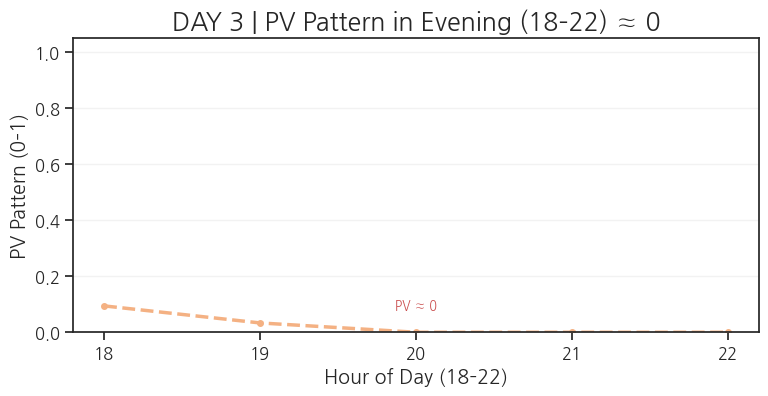

In [15]:
# =========================
# 구간 / 색상
# =========================
EV_START, EV_END = 18, 22
PV_COLOR  = "#F4B183"   # 주황 (PV)
CALM_RED  = "#C94A4A"   # 포인트 레드

# =========================
# 데이터
# =========================
m = merged_A[(merged_A["hour"] >= EV_START) & (merged_A["hour"] <= EV_END)].copy()

# =========================
# Figure
# =========================
plt.figure(figsize=(7, 3))

plt.plot(
    m["hour"], m["pv_norm"],
    color=PV_COLOR,
    linewidth=2.5,
    marker="o",
    markersize=4,
    linestyle="--",
    label="PV Pattern (0–1)"
)

plt.xticks(range(EV_START, EV_END + 1))
plt.ylim(0, 1.05)

# Grid (y축만, 은은하게)
plt.grid(axis="y", alpha=0.25)

# 축 / 제목
plt.xlabel("Hour of Day (18–22)")
plt.ylabel("PV Pattern (0–1)")
plt.title("DAY 3 | PV Pattern in Evening (18–22) ≈ 0")

# =========================
# 간단한 강조 텍스트 (화살표 없이)
# =========================
mid_hour = int(m["hour"].median())
mid_val  = float(m.loc[m["hour"] == mid_hour, "pv_norm"].iloc[0])

plt.text(
    mid_hour,
    mid_val + 0.08,
    "PV ≈ 0",
    color=CALM_RED,
    ha="center",
    fontsize=9
)

# =========================
# 저장
# =========================
plt.savefig(
    FIG_DIR / f"DAY3_pv_evening_pattern_{EV_START}-{EV_END}.png",
    **SAVE_KWARGS
)

plt.show()